In [1]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras import backend as K

Using TensorFlow backend.


In [2]:
# array stacking
def create_sequence(df, cols, time_indexes, target):
  seqs = []
  for col in cols:
    seq = df[col].values.reshape((len(df[col]), 1))
    seqs.append(seq)
  for index in time_indexes:
    seq = index.values.reshape((len(df[col]), 1))
    seqs.append(seq)
  seq = df[target].values.reshape((len(df[target]), 1))
  for i in range(len(seq)):
    if seq[i] < 0:
      seq[i] = 0
  seqs.append(seq)
  dataset = np.hstack((seqs))  
  return dataset

def split_sequence_multi(sequence, n_steps, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    out_ix = end_ix + n_steps_out
    # boundary check
    if out_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

## Solar power forecasting

In [3]:
df = pd.read_csv('../LSTM-power-forecasting/pvdaq_2012_2014_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [4]:
# columns to use for forecasting
cols = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 
        'relative_humidity', 'wind_direction', 'wind_speed']
time_indexes = [df.index.hour, df.index.month]
# we will forecast dc power output
target = ['dc_power']

In [5]:
dataset = (create_sequence(df, cols, time_indexes, target))
X, y = split_sequence_multi(dataset, 12, 6)
print(X.shape, y.shape)

(26287, 12, 10) (26287, 6)


In [6]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
n_features=X.shape[2]
X, y = split_sequence_multi(dataset, n_steps, n_steps_out)
train_X, train_y = X[:-2000,:], y[:-2000,:]
val_X, val_y = X[-2000:-1000,:], y[-2000:-1000,:]
test_X, test_y = X[-1000:,:], y[-1000:,:]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))

test_seq1 = []
pred_seq1 = []
for i in range(36):
  test_seq1 = np.concatenate((test_seq1, test_y[i*6]))
  pred_seq1 = np.concatenate((pred_seq1, predictions[i*6]))

Train on 24275 samples, validate on 1000 samples
Epoch 1/20
24275/24275 [==============================] - 109s 4ms/step - loss: 7059.2263 - val_loss: 5562.8742
Epoch 2/20
24275/24275 [==============================] - 109s 4ms/step - loss: 4433.8145 - val_loss: 2671.7201
Epoch 3/20
24275/24275 [==============================] - 112s 5ms/step - loss: 3387.4710 - val_loss: 3164.4945
Epoch 4/20
24275/24275 [==============================] - 107s 4ms/step - loss: 3548.4799 - val_loss: 3817.4578
Epoch 5/20
24275/24275 [==============================] - 107s 4ms/step - loss: 3229.8008 - val_loss: 1756.4224
Epoch 6/20
24275/24275 [==============================] - 108s 4ms/step - loss: 2123.3318 - val_loss: 1667.8153
Epoch 7/20
24275/24275 [==============================] - 107s 4ms/step - loss: 2075.6797 - val_loss: 1688.8832
Epoch 8/20
24275/24275 [==============================] - 107s 4ms/step - loss: 2329.2322 - val_loss: 1849.6766
Epoch 9/20
24275/24275 [==============================]

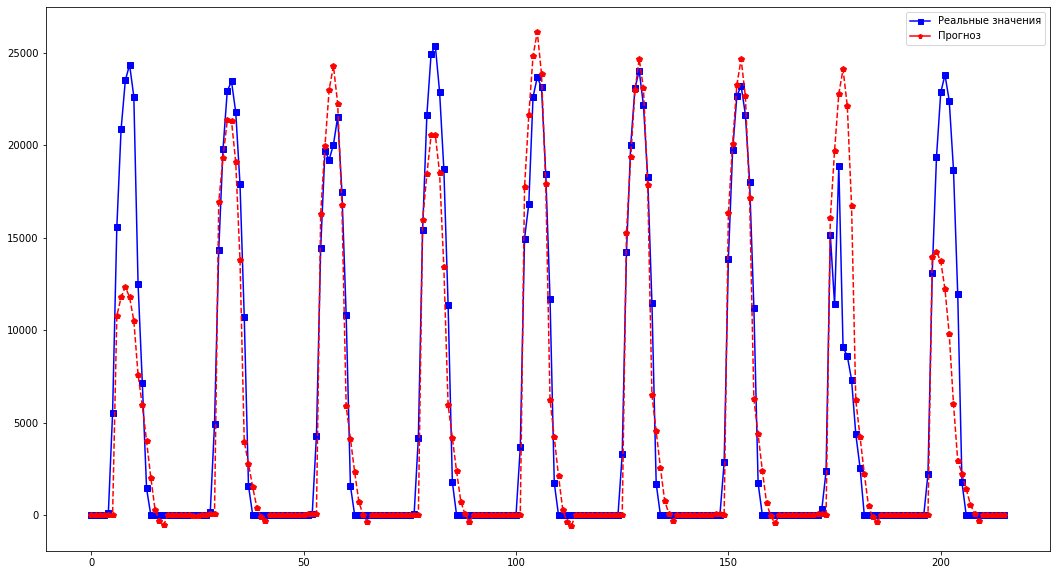

In [7]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(test_seq1, 'b-s')
plt.plot(pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

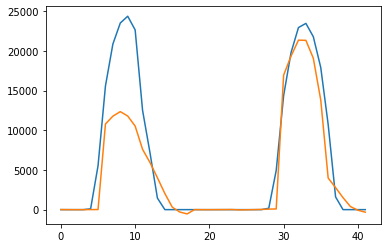

In [8]:
test_seq = np.concatenate((test_y[0], test_y[6], test_y[12], test_y[18], test_y[24], test_y[30], test_y[36]))
pred_seq = np.concatenate((predictions[0], predictions[6], predictions[12], predictions[18], predictions[24], predictions[30], predictions[36]))
plt.plot(test_seq)
plt.plot(pred_seq)

In [9]:
solar_preds = pred_seq1

## Power consumption forecasting

In [10]:
house_df = pd.read_csv('datasets/KAG_energydata_complete.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])

In [11]:
house_df.head(20)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,45.730000,...,17.000000,45.290000,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,45.790000,...,17.000000,45.290000,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,45.863333,...,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,45.790000,...,17.000000,45.290000,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702


In [12]:
house_df['consumption'] = house_df['Appliances'] + house_df['lights']
# resampling dataframe to hourly format to match everything
#resampled_wind_df = wind_df.resample('1H').median().drop(['consumption', 'Appliances', 'lights'], axis=1)
#resampled_wind_df['consumption'] = wind_df.resample('1H').sum()['consumption']
#wind_df = resampled_wind_df

cols = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
target = ['consumption']
time_indexes = [house_df.index.hour, house_df.index.dayofweek, house_df.index.month]
house_dataset = create_sequence(house_df, cols, time_indexes, target)

In [63]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(house_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:14000,:], y[:14000,:]
val_X, val_y = X[14000:16000,:], y[14000:16000,:]
test_X, test_y = X[16000:,:], y[16000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(350, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(250, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(train_X, train_y, batch_size=16, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



train: 14000 val: 2000 test: 3706
Train on 14000 samples, validate on 2000 samples
Epoch 1/20
14000/14000 [==============================] - 146s 10ms/step - loss: 891143.4112 - val_loss: 11516.1049
Epoch 2/20
14000/14000 [==============================] - 137s 10ms/step - loss: 13205.5575 - val_loss: 11978.2765
Epoch 3/20
14000/14000 [==============================] - 138s 10ms/step - loss: 13028.0009 - val_loss: 11151.9976
Epoch 4/20
14000/14000 [==============================] - 136s 10ms/step - loss: 15060.7699 - val_loss: 11398.3460
Epoch 5/20
14000/14000 [==============================] - 176s 13ms/step - loss: 12938.5754 - val_loss: 10186.0812
Epoch 6/20
14000/14000 [==============================] - 171s 12ms/step - loss: 12692.3389 - val_loss: 11333.1474
Epoch 7/20
14000/14000 [==============================] - 139s 10ms/step - loss: 12372.6760 - val_loss: 9256.6897
Epoch 8/20
14000/14000 [==============================] - 136s 10ms/step - loss: 12172.7221 - val_loss: 9665.392

In [64]:
house_test_seq1 = []
house_pred_seq1 = []
for i in range(216):
  house_test_seq1 = np.concatenate((house_test_seq1, test_y[i*6]))
  house_pred_seq1 = np.concatenate((house_pred_seq1, predictions[i*6]))

# resampling into hourly format
house_test_seq = []
for i in range(len(house_test_seq1)//6):
    house_test_seq.append(house_test_seq1[6*i:6*i+6].sum())

house_pred_seq = []
for i in range(len(house_pred_seq1)//6):
    house_pred_seq.append(house_pred_seq1[6*i+12:6*i+18].sum())

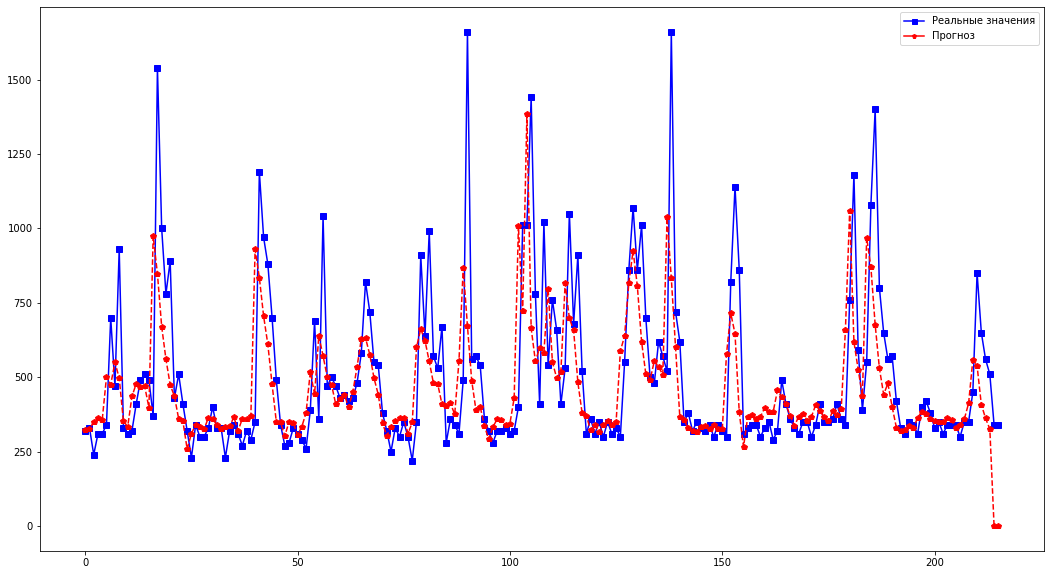

In [65]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(house_test_seq, 'b-s')
plt.plot(house_pred_seq, 'r--p')
plt.legend(handles=[blue_line, red_line])

In [67]:
house_preds = house_pred_seq

## Wind power forecasting

In [17]:
wind_df = pd.read_csv('datasets/T1.csv', header=0, infer_datetime_format=True, parse_dates=['Date/Time'], index_col=['Date/Time'])

In [18]:
wind_df

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500


In [20]:
cols = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = ['LV ActivePower (kW)']
time_indexes = [wind_df.index.hour, wind_df.index.month]
wind_dataset = create_sequence(wind_df, cols, time_indexes, target)


In [22]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(wind_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:30000,:], y[:30000,:]
val_X, val_y = X[30000:40000,:], y[30000:40000,:]
test_X, test_y = X[40000:,:], y[40000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 14, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



train: 30000 val: 10000 test: 10501
Train on 30000 samples, validate on 10000 samples
Epoch 1/14
30000/30000 [==============================] - 142s 5ms/step - loss: 838.5526 - val_loss: 1903.3866
Epoch 2/14
30000/30000 [==============================] - 144s 5ms/step - loss: 776.2534 - val_loss: 503.2756
Epoch 3/14
30000/30000 [==============================] - 146s 5ms/step - loss: 658.5242 - val_loss: 569.2282
Epoch 4/14
30000/30000 [==============================] - 143s 5ms/step - loss: 527.5176 - val_loss: 554.4184
Epoch 5/14
30000/30000 [==============================] - 144s 5ms/step - loss: 499.5648 - val_loss: 569.2253
Epoch 6/14
30000/30000 [==============================] - 144s 5ms/step - loss: 515.0547 - val_loss: 939.7804
Epoch 7/14
30000/30000 [==============================] - 144s 5ms/step - loss: 527.0638 - val_loss: 887.9117
Epoch 8/14
30000/30000 [==============================] - 145s 5ms/step - loss: 573.7813 - val_loss: 514.3758
Epoch 9/14
30000/30000 [=========

In [23]:
predictions1 = model.predict(test_X)
mse = mean_squared_error(test_y, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test_y, predictions)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))

MSE: 659000.0 RMSE: 812 MAE: 541.0


In [32]:
wind_test_seq1 = []
wind_pred_seq1 = []

for i in range(216):
  wind_test_seq1 = np.concatenate((wind_test_seq1, test_y[i*6]))
  wind_pred_seq1 = np.concatenate((wind_pred_seq1, predictions[i*6]))

wind_test_seq = []
for i in range(len(wind_test_seq1)//6):
    wind_test_seq.append(wind_test_seq1[6*i:6*i+6].sum())

wind_pred_seq = []
for i in range(len(wind_pred_seq1)//6):
    wind_pred_seq.append(wind_pred_seq1[6*i+12:6*i+18].sum())

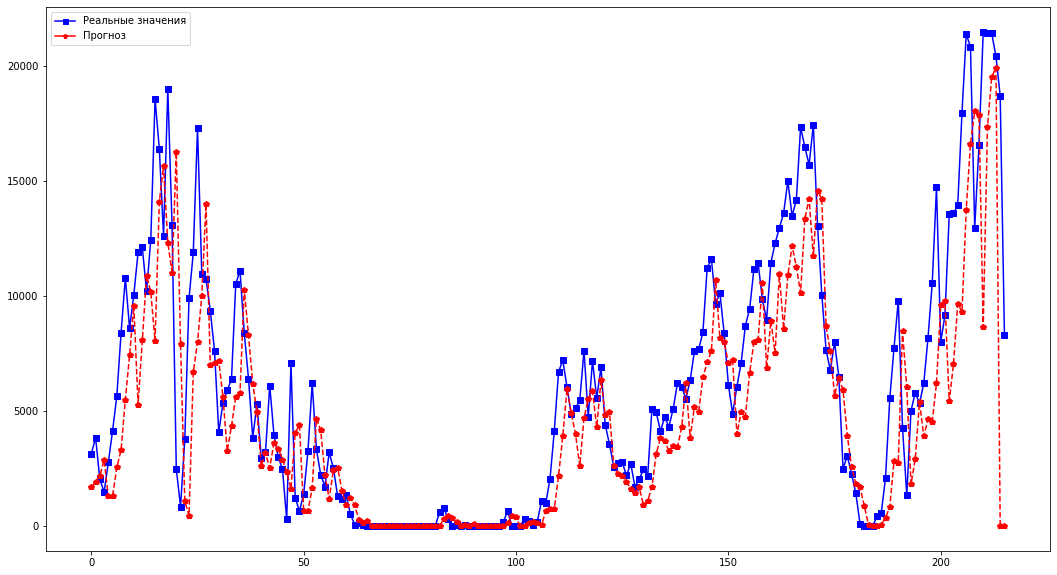

In [66]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(wind_test_seq, 'b-s')
plt.plot(wind_pred_seq, 'r--p')
plt.legend(handles=[blue_line, red_line])

In [26]:
wind_preds = wind_pred_seq

## Power optimization

In [27]:
solar_preds
wind_preds
house_preds

array([98.85097504, 98.04019928, 91.64965057, ..., 79.49362946,
       81.29176331, 78.99937439])

In [140]:
house_preds_scaled = [item*10 for item in house_preds]
wind_preds_scaled = [item*2 for item in wind_preds]
solar_preds_scaled = [(0 if x<0 else x) for x in solar_preds]

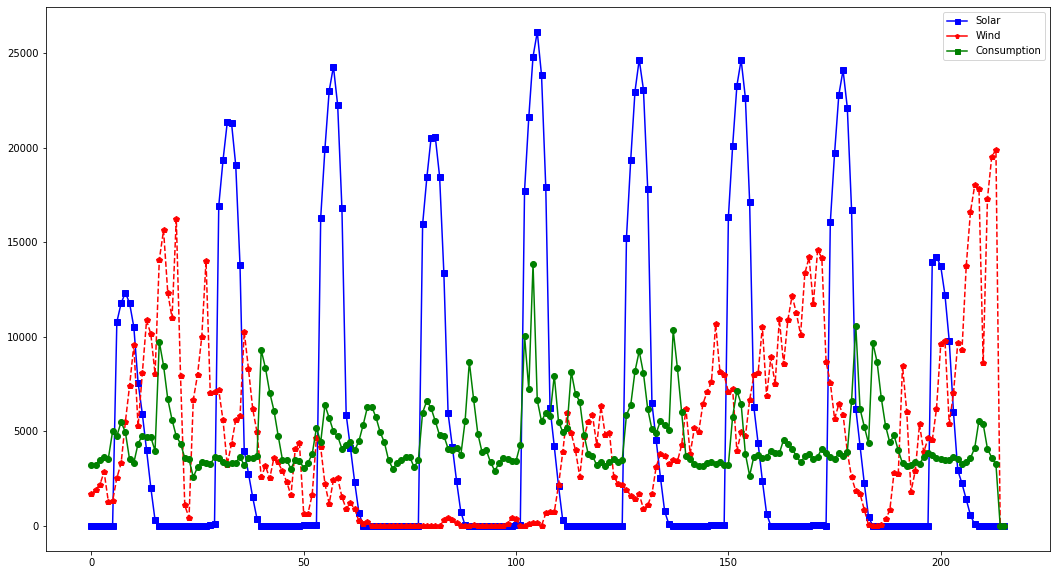

In [141]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Solar')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Wind')
green_line = mlines.Line2D([], [], color='green', marker='s',
                          markersize=5, label='Consumption')
black_line = mlines.Line2D([], [], color='black', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(solar_preds_scaled, 'b-s')
plt.plot(wind_preds, 'r--p')
plt.plot(house_preds_scaled, 'g-o')
plt.legend(handles=[blue_line, red_line, green_line])

In [142]:
merged_preds = []
for i in range(len(solar_preds)):
    temp_list = [solar_preds_scaled[i], wind_preds[i], house_preds_scaled[i]]
    merged_preds.append(temp_list)

In [143]:
solution_seq = []
storage_value = 0
storage_value_capacity = 18000
for row in merged_preds:
    # row contains maximum possible amount of energy output
    problem = LpProblem("power_optimization", LpMinimize)

    # Prices for energy
    solar_price = 0
    wind_price = 0
    grid_price = 3
    storage_price = 0.1

    # Energy demand
    demand = row[2]

    # Variables
    solar_power = LpVariable('solar_power', 0, row[0])
    wind_power = LpVariable('wind_power', 0, row[1])
    grid_power = LpVariable('grid_power', 0, 10000)
    storage_power = LpVariable('storage_power', 0, storage_value)

    # Constraints
    c1 = solar_power + wind_power + grid_power + storage_power >= demand

    # Objective
    objective = solar_power*solar_price + wind_power*wind_price + grid_power*grid_price + storage_power*storage_price

    # Adding constraints and objectives to problem
    problem += c1
    problem += objective

    #Solving
    #print(problem)
    problem.solve()
    
    # Hacky implementation of power storage
    # Unused solar and wind power goes straight into power storage
    if (value(solar_power)+value(wind_power)>value(demand)):
        storage_value=storage_value + (value(solar_power)+value(wind_power)) - value(demand)
        if storage_value > storage_value_capacity:
            storage_value=storage_value_capacity
        print(storage_value)
    else:
        storage_value = storage_value - value(storage_power)

    # Print solution
    for i in [solar_power, wind_power, grid_power, storage_power, objective]:
        print(i,"=" ,value(i))
    

        
    temp_seq = [value(demand), value(solar_power), value(wind_power), value(grid_power), value(storage_power), storage_value, value(objective)]
    solution_seq.append(temp_seq)
    
results = pd.DataFrame(solution_seq, columns=['Demand', 'Solar', 'Wind', 'Grid', 'Storage', 'Stored Energy', 'Objective'])

solar_power = 8.621727
wind_power = 1682.4988
grid_power = 1532.8227
storage_power = 0.0
3*grid_power + 0.1*storage_power = 4598.4681
solar_power = 0.0
wind_power = 1930.1318
grid_power = 1320.3447
storage_power = 0.0
3*grid_power + 0.1*storage_power = 3961.0341000000003
solar_power = 0.0
wind_power = 2175.8932
grid_power = 1331.7619
storage_power = 0.0
3*grid_power + 0.1*storage_power = 3995.2857
solar_power = 0.0
wind_power = 2864.7681
grid_power = 769.89605
storage_power = 0.0
3*grid_power + 0.1*storage_power = 2309.68815
solar_power = 4.0725226
wind_power = 1292.4524
grid_power = 2272.1809
storage_power = 0.0
3*grid_power + 0.1*storage_power = 6816.5427
solar_power = 11.813993
wind_power = 1308.0218
grid_power = 3681.3947
storage_power = 0.0
3*grid_power + 0.1*storage_power = 11044.184099999999
8572.898140283203
solar_power = 10782.932
wind_power = 2545.4561
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 11769.04
wind_power = 3306.42

solar_power = 0.0
wind_power = 0.5889014
grid_power = 5760.0516
storage_power = 5e-05
3*grid_power + 0.1*storage_power = 17280.154805000002
solar_power = 0.0
wind_power = 2.6266797
grid_power = 4966.1553
storage_power = 0.0
3*grid_power + 0.1*storage_power = 14898.465900000001
solar_power = 0.0
wind_power = 0.72758883
grid_power = 4417.2796
storage_power = 0.0
3*grid_power + 0.1*storage_power = 13251.8388
solar_power = 5.1437488
wind_power = -1.3636568
grid_power = 3467.5665
storage_power = 0.0
3*grid_power + 0.1*storage_power = 10402.699499999999
solar_power = 10.824293
wind_power = -0.54810336
grid_power = 3014.8255
storage_power = 0.0
3*grid_power + 0.1*storage_power = 9044.4765
solar_power = 6.4133649
wind_power = 0.057147473
grid_power = 3336.3888
storage_power = 0.0
3*grid_power + 0.1*storage_power = 10009.1664
solar_power = 0.0
wind_power = 0.54734421
grid_power = 3515.5932
storage_power = 0.0
3*grid_power + 0.1*storage_power = 10546.7796
solar_power = 0.0
wind_power = -1.720428

18000
solar_power = 23069.957
wind_power = 912.41783
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 17841.555
wind_power = 1099.9778
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 6485.6987
wind_power = 1688.8387
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 4543.7222
wind_power = 3135.7507
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 2561.675
wind_power = 3811.1042
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
solar_power = 769.4892
wind_power = 3679.5932
grid_power = 0.0
storage_power = 893.3246
3*grid_power + 0.1*storage_power = 89.33246000000001
solar_power = 84.848511
wind_power = 3259.5512
grid_power = 0.0
storage_power = 1745.3376
3*grid_power + 0.1*storage_power = 174.53376000000003
solar_power = 0.0
wind_power = 3486.0969
grid_power = 0.0
storage_power

18000
solar_power = 9785.5039
wind_power = 5411.7964
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 6021.8784
wind_power = 7023.0421
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 2957.5044
wind_power = 9650.8013
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 2248.3628
wind_power = 9292.3246
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 1417.1772
wind_power = 13741.047
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 568.69244
wind_power = 16611.18
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 81.304649
wind_power = 18013.038
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 17832.793
grid_power = 0.0
storage_power = 0.0
3*grid_power +

In [144]:
results

,Demand,Solar,Wind,Grid,Storage,Stored Energy,Objective
0,3223.943214,8.621727,1682.4988,1532.82270,0.0,0.0,4598.46810
1,3250.476494,0.000000,1930.1318,1320.34470,0.0,0.0,3961.03410
2,3507.655067,0.000000,2175.8932,1331.76190,0.0,0.0,3995.28570
3,3634.664116,0.000000,2864.7681,769.89605,0.0,0.0,2309.68815
4,3568.705826,4.072523,1292.4524,2272.18090,0.0,0.0,6816.54270
...,...,...,...,...,...,...,...
211,4082.945938,0.000000,17312.0390,0.00000,0.0,18000.0,0.00000
212,3617.721252,0.000000,19506.7270,0.00000,0.0,18000.0,0.00000
213,3261.845398,0.000000,19902.7810,0.00000,0.0,18000.0,0.00000
214,0.000000,0.000000,0.0000,0.00000,0.0,18000.0,0.00000


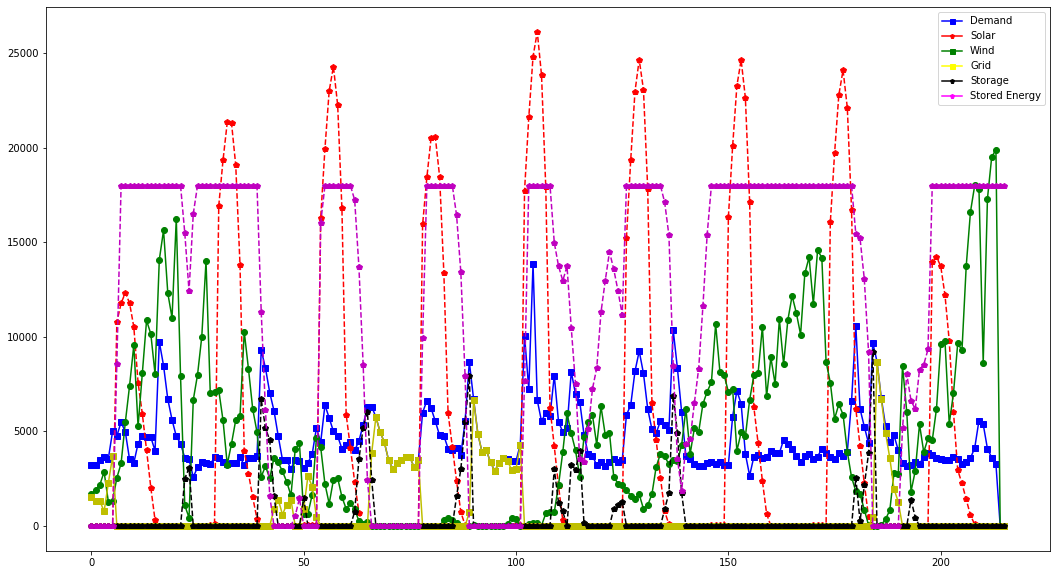

In [145]:
plt.figure(figsize=(18,10))
plt.plot(results['Demand'], 'b-s')
plt.plot(results['Solar'], 'r--p')
plt.plot(results['Wind'], 'g-o')
plt.plot(results['Grid'], 'y-s')
plt.plot(results['Storage'], 'k--p')
plt.plot(results['Stored Energy'], 'm--p')

blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Demand')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Solar')
green_line = mlines.Line2D([], [], color='green', marker='s',
                          markersize=5, label='Wind')
yellow_line = mlines.Line2D([], [], color='yellow', marker='s',
                          markersize=5, label='Grid')
black_line = mlines.Line2D([], [], color='black', marker='p',
                          markersize=5, label='Storage')
magenta_line = mlines.Line2D([], [], color='magenta', marker='p',
                          markersize=5, label='Stored Energy')

plt.legend(handles=[blue_line, red_line, green_line, yellow_line, black_line, magenta_line])